## Backtesting 

### Store Metrics/Plot Visualisations here

In [159]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('..')
from strategies.mean_reversion import MeanReversionStrat, Trade
from utilities.api_client import APIClient
from strategies.indicators import rsi, bb, atr, std_dev

# Load config
with open('../config.json', 'r') as f:
    config = json.load(f)

# Initialize backtest parameters
INITIAL_BALANCE_USDT = 10000  # Starting with 10k USDT
TRADING_FEES = 0.001  # 0.1% maker/taker fee on Binance



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
class Backtest:
    # TODO: Make strategy class for just buy and hold lol to plot 
    # Make backtest class support different strategies
    def __init__(self, strategy: MeanReversionStrat):
        self.strategy = strategy
        self.equity_curve = [{
            'timestamp': strategy.env.get_current_time(),
            'equity': strategy.env.get_equity(position=strategy.pos, pos_size=strategy.pos_size)
        }]

    def run(self):
        #make for loop until no more data left with update period function
        trade_file_path = 'trades/mean_reversion_trades.csv'
        if Path(trade_file_path).exists():
            with open(trade_file_path, 'w') as file:
                file.write('')

        while self.strategy.env.get_current_data() is not None:
            signal = self.strategy.gen_signal()

            # yea this is stupid but for readability
            if signal != "flat":
                trade = self.strategy.enter_position(signal)
                print("SL Dist: ", self.strategy.sl_dist(signal))
                print("Position size: ", self.strategy.pos_size)
                self.strategy.save_trade(trade, 'trades/mean_reversion_trades.csv')

            # self.times.append(self.strategy.env.get_current_time())
            self.equity_curve.append({
                'timestamp': self.strategy.env.get_current_time(),
                'equity': self.strategy.env.get_equity(position=self.strategy.pos, pos_size=self.strategy.pos_size)
            })
            print('timestamp: ', self.strategy.env.get_current_time())
            print('equity: ', self.strategy.env.get_equity(position=self.strategy.pos, pos_size=self.strategy.pos_size))
            print('balance: ', self.strategy.env.get_balance())
            self.strategy.env.update_period()


    def plot_equity_curve(self):
        equity_df = pd.DataFrame(self.equity_curve)
        plt.figure(figsize=(10, 6))

        data = self.strategy.env.data
        initial_btc = INITIAL_BALANCE_USDT/data['close'][len(data)-len(equity_df)]
        print("BRUHHHHHH", data['close'][len(data)-len(equity_df)]*initial_btc)
        plt.plot(data['timestamp'][-len(equity_df):], data['close'][-len(equity_df):]*initial_btc, label='Buy and Hold')

        plt.plot(equity_df['timestamp'], equity_df['equity'], label='Strategy')
        # plt.plot(data['timestamp'], equity_df['equity'], label='Equity Curve')


        plt.xlabel('Timestamp')
        plt.ylabel('Value (USDT)')
        plt.title('Strategy vs Buy and Hold')
        plt.legend()
        plt.show()

    def get_metrics(self):
        risk_free_rate = 0.0435
        returns = np.diff(self.equity_curve)
        avg_return = np.mean(returns)
        std_dev = np.std(returns)

        sharpe_ratio = (avg_return-risk_free_rate)/std_dev
        print(f'Sharpe Ratio: {sharpe_ratio}')

### Historical Data Retrieval

First, we connect to the $\texttt{ccxt}$ API to access historical OHLCV data of our chosen pairs.

In [150]:
from keys import API_KEY, API_SECRET

client = APIClient(config, API_KEY, API_SECRET)
client.exchange.enableRateLimit = True
client.exchange.options['adjustForTimeDifference'] = True
historical_data = client.fetch_ohlcv_df('ETH/USDT', period=1000)
display(historical_data)

,timestamp,open,high,low,close,volume
0,2022-03-20,2950.85,2964.17,2817.21,2861.38,377608.8214
1,2022-03-21,2861.39,2960.57,2829.81,2890.03,450223.9073
2,2022-03-22,2890.03,3052.85,2886.43,2969.64,564868.9839
3,2022-03-23,2969.64,3045.20,2920.65,3036.00,453962.7298
4,2022-03-24,3035.99,3129.11,2999.11,3110.76,577171.5239
...,...,...,...,...,...,...
995,2024-12-09,4004.15,4006.17,3509.00,3712.00,939642.2001
996,2024-12-10,3712.00,3780.76,3515.89,3628.25,942206.0337
997,2024-12-11,3628.24,3848.64,3562.34,3831.81,461818.7801
998,2024-12-12,3831.82,3987.41,3796.80,3881.61,572098.6343


### Initialising a Mean Reversion Strategy

,timestamp,open,high,low,close,volume
0,2022-03-20,2950.85,2964.17,2817.21,2861.38,3.776088e+05
1,2022-03-21,2861.39,2960.57,2829.81,2890.03,4.502239e+05
2,2022-03-22,2890.03,3052.85,2886.43,2969.64,5.648690e+05
3,2022-03-23,2969.64,3045.20,2920.65,3036.00,4.539627e+05
4,2022-03-24,3035.99,3129.11,2999.11,3110.76,5.771715e+05
...,...,...,...,...,...,...
95,2022-06-23,1050.19,1155.00,1045.30,1144.72,1.278257e+06
96,2022-06-24,1144.71,1245.43,1132.00,1225.02,1.337137e+06
97,2022-06-25,1225.02,1256.77,1180.00,1242.36,8.619866e+05
98,2022-06-26,1242.31,1280.00,1194.60,1197.79,8.841843e+05


current time 2022-06-27 00:00:00
current period 0
no signal
timestamp:  2022-06-27 00:00:00
equity:  10000
balance:  10000
current time 2022-06-28 00:00:00
current period 1
no signal
timestamp:  2022-06-28 00:00:00
equity:  10000
balance:  10000
current time 2022-06-29 00:00:00
current period 2
no signal
timestamp:  2022-06-29 00:00:00
equity:  10000
balance:  10000
current time 2022-06-30 00:00:00
current period 3
no signal
timestamp:  2022-06-30 00:00:00
equity:  10000
balance:  10000
current time 2022-07-01 00:00:00
current period 4
no signal
timestamp:  2022-07-01 00:00:00
equity:  10000
balance:  10000
current time 2022-07-02 00:00:00
current period 5
no signal
timestamp:  2022-07-02 00:00:00
equity:  10000
balance:  10000
current time 2022-07-03 00:00:00
current period 6
no signal
timestamp:  2022-07-03 00:00:00
equity:  10000
balance:  10000
current time 2022-07-04 00:00:00
current period 7
no signal
timestamp:  2022-07-04 00:00:00
equity:  10000
balance:  10000
current time 202

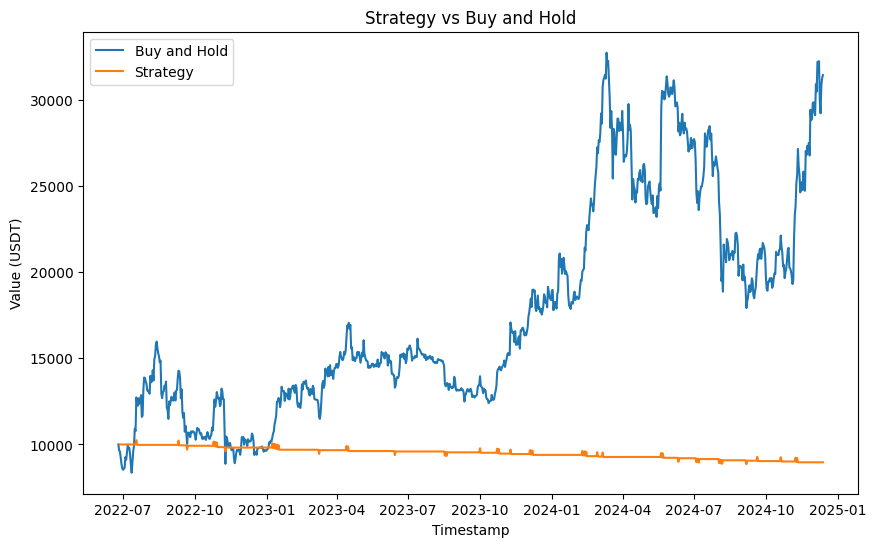

<bound method Backtest.get_metrics of <__main__.Backtest object at 0x0000026C58D0B470>>

In [161]:
strategy = MeanReversionStrat(config=config,
                              env_type='backtest',
                              initial_balance=INITIAL_BALANCE_USDT,
                              data=historical_data)
print(strategy.env)
display(strategy.env.get_current_data())

first_test = Backtest(strategy)
first_test.run()
first_test.plot_equity_curve()
first_test.get_metrics



In [152]:
class Backtest:
    def __init__(self, strategy, data, initial_balance):
        self.strategy = strategy
        self.data = data
        self.balance = initial_balance
        self.positions = []
        self.trades = []
        self.equity_curve = []
        
    def run(self):
        # Iterate through each day in the data
        for i in range(len(self.data)):
            current_data = self.data.iloc[:i+1]
            if len(current_data) < 20:  # Need enough data for indicators
                continue
                
            # Get signal from strategy
            signal = self.strategy.gen_signal(current_data)
            
            # Execute trades based on signal
            if signal != 0:
                # Calculate position size based on risk management
                size = self.strategy.pos_size
                
                # Include trading fees
                fee = size * current_data.iloc[-1]['close'] * TRADING_FEES
                
                # Execute trade
                self.strategy.execute_trade(signal, current_data, size)
                
                # Update balance
                self.balance -= fee
            
            # Record equity at this point
            total_equity = self.balance
            if self.strategy.pos != 0:
                # Add unrealized P&L if we have an open position
                current_price = current_data.iloc[-1]['close']
                total_equity += self.strategy.pos_size * current_price
                
            self.equity_curve.append({
                'timestamp': current_data.iloc[-1]['timestamp'],
                'equity': total_equity
            })
            
    def get_results(self):
        equity_df = pd.DataFrame(self.equity_curve)
        
        # Calculate basic metrics
        total_return = (equity_df['equity'].iloc[-1] - INITIAL_BALANCE_AUD) / INITIAL_BALANCE_AUD
        
        # Calculate drawdown
        equity_df['peak'] = equity_df['equity'].cummax()
        equity_df['drawdown'] = (equity_df['peak'] - equity_df['equity']) / equity_df['peak']
        max_drawdown = equity_df['drawdown'].max()
        
        return {
            'total_return': total_return,
            'max_drawdown': max_drawdown,
            'num_trades': len(self.strategy.trades),
            'equity_curve': equity_df
        }

# Fetch historical data
client = APIClient(config, "", "")  # Empty strings for API keys since we're just backtesting
historical_data = client.fetch_ohlcv_df('BTC/AUD')

# Initialize strategy
strategy = MeanReversionStrat(config=config, api_key="", api_secret="")

# Run backtest
backtest = Backtest(strategy, historical_data, INITIAL_BALANCE_AUD)
backtest.run()

# Get and display results
results = backtest.get_results()
print(f"Total Return: {results['total_return']*100:.2f}%")
print(f"Max Drawdown: {results['max_drawdown']*100:.2f}%")
print(f"Number of Trades: {results['num_trades']}")

# Plot equity curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results['equity_curve']['timestamp'], results['equity_curve']['equity'])
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (AUD)')
plt.grid(True)
plt.show()


TypeError: APIClient.fetch_ohlcv_df() missing 1 required positional argument: 'period'